After loading data from Timber, it has to be preprocessed. It has to be decided when the source was stable, when voltage breakdowns occured an so on. These are tasks that in practice only have to be done once, which is the reason why this notebook exists. One is able to specify a raw data file and this notebook will export a labeled one together with visualizations of the performed tasks so that a visual quality check can be done.

In [24]:
# %load ../ionsrcopt/load_data.py
import pandas as pd
import numpy as np

def read_data_from_csv(filename, cols_to_read, rows_to_read):
    """ Read a csv file into a DataFrame

    Parameters:
        filename (string): Filename
        cols_to_read (list of string): The column names to read, None if everything should be read
        rows_to_read (list of int): The rown numbers to read, None if everything should be read

    Returns:
        DataFrame
    """

    print("Loading data from csv file \'{}\'".format(filename))
    if cols_to_read is None:
        df = pd.read_csv(filename).fillna(method='ffill')
    else:
        df = pd.read_csv(filename, usecols=cols_to_read).fillna(method='ffill')

    if rows_to_read is None:
        return df
    else:
        return df.iloc[rows_to_read]

def convert_column(df, column, type):
    """ Converts the dtype of a column

    Parameters:
        df (DataFrame): The DataFrame containing the column
        column (string): The column name
        type (string): dtype the column should be converted to

    Returns:
        DataFrame: The altered DataFrame or the old one, if it did not contain the specified column
    """

    if column in df.columns:
        print("Converting column \'{}\' to \'{}\'".format(column, type))
        return df.astype({column:type})
    else:
        print("Column \'{}\' does not exist".format(column))
        return df

def convert_column_types(df):
    """ Convert all columns of a Dataframe of measurements to single precision values.

    Parameters:
        df (DataFrame): DataFrame to be altered

    Returns:
        DataFrame
    """

    print("Started type conversion of columns...")
    if 'Timestamp (UTC_TIME)' in df.columns:
        print("Converting column \'{}\' to \'{}\'".format('Timestamp (UTC_TIME)', 'datetime'))
        df['Timestamp (UTC_TIME)'] = pd.to_datetime(df['Timestamp (UTC_TIME)']) 
    df = convert_column(df, 'IP.NSRCGEN:BIASDISCAQNV', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:GASSASAQN', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:SOURCEHTAQNI', 'float32')
    df = convert_column(df, 'IP.SAIREM2:FORWARDPOWER', 'float32')
    df = convert_column(df, 'IP.SOLCEN.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLEXT.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLINJ.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT15:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT25:CURRENT', 'float32')
    df = convert_column(df, 'ITH.BCT41:CURRENT', 'float32')
    df = convert_column(df, 'ITL.BCT05:CURRENT', 'float32')
    return df

def clean_data(df):
    """ Clean the data of measurements, that are outliers, e.g. spikes in the extraction current.

    Parameters:
        df (DataFrame): DataFrame containing the measurements.

    Returns:
        DataFrame: Cleaned data.
    """

    print("Filtering data...")
    if 'ITF.BCT15:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT15:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITF.BCT25:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT25:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITH.BCT41:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT41:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITL.BCT05:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT05:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'IP.NSRCGEN:OVEN1AQNP' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:OVEN1AQNP'].apply(lambda x: np.nan if x < 4.5 else x)
    if 'IP.SOLEXT.ACQUISITION:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.SOLEXT.ACQUISITION:CURRENT'].apply(lambda x: np.nan if x < 1200 else x)
    if 'IP.NSRCGEN:BIASDISCAQNV' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:BIASDISCAQNV'].apply(lambda x: np.nan if x == 0 else x)
    if 'IP.SAIREM2:FORWARDPOWER' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.SAIREM2:FORWARDPOWER'].apply(lambda x: np.nan if x < 500 else x)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:SOURCEHTAQNI'].apply(lambda x: np.nan if x > 2.5 else x)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:SOURCEHTAQNI'].apply(lambda x: np.nan if x < 0.5 else x)
    
    return df

First we need to read the data into a dataframe that we will manipulate and save afterwards. We will not do any column preselection at this point.

In [38]:
input_file = '../Data_Raw/Nov2015.csv'
output_file = '../Data_Preprocessed/Nov2015.csv'

In [39]:
df = read_data_from_csv(input_file, None, None)
df = convert_column_types(df)
df.dropna(inplace=True)
df.shape

Loading data from csv file '../Data_Raw/Nov2015.csv'
Started type conversion of columns...
Converting column 'Timestamp (UTC_TIME)' to 'datetime'
Converting column 'IP.NSRCGEN:BIASDISCAQNV' to 'float32'
Converting column 'IP.NSRCGEN:GASSASAQN' to 'float32'
Converting column 'IP.NSRCGEN:SOURCEHTAQNI' to 'float32'
Column 'IP.SAIREM2:FORWARDPOWER' does not exist
Converting column 'IP.SOLCEN.ACQUISITION:CURRENT' to 'float32'
Converting column 'IP.SOLEXT.ACQUISITION:CURRENT' to 'float32'
Column 'IP.SOLINJ.ACQUISITION:CURRENT' does not exist
Column 'ITF.BCT15:CURRENT' does not exist
Converting column 'ITF.BCT25:CURRENT' to 'float32'
Column 'ITH.BCT41:CURRENT' does not exist
Column 'ITL.BCT05:CURRENT' does not exist


(450860, 9)

The first thing we are going to do, is marking the source as stable/unstable. The parameters used are from experiments on the Nov2018 data.

In [40]:
# %load ../ionsrcopt/source_stability.py
import pandas as pd
import numpy as np

def stability_mean_variance_classification(df, current_column, sliding_window_size=5000, minimum_mean=0.025, maximum_variance=0.00005):
    """ Classifies all point in the data frame into the categories source stable/unstable, based on a rolling window and a minimum mean and maximum variance in this window.

    Parameters:
        df (DataFrame): The data input loaded as a DataFrame
        current_column (string): name of the column that contains the beam current we are interested in, typically BCT25
        sliding_window_size (int): size of the sliding window, by default 5000 (100 Minutes of data every 1.2 seconds)
        minimum_mean (double): minimal intensity of the beam in the sliding window for it to be considered stable
        maximum_variance (double): maximum variance of intensity of the beam in the sliding window for it to be considered stable

    Returns:
        Series: A series that for every data point indicates if the source was running stable or not (1 is stable, 0 is unstable)
    """

    mean = np.array(df[current_column].rolling(sliding_window_size).mean())
    var = np.array(df[current_column].rolling(sliding_window_size).var())

    result = [int(m > minimum_mean and v < maximum_variance) if not np.isnan(m) and not np.isnan(v) else np.nan for (m, v) in zip(mean, var)]
    return pd.Series(result, index=df.index)

In [41]:
column = 'ITF.BCT25:CURRENT'
sliding_window_size=2000
minimum_mean=0.022
#minimum_mean=0.027 #for Nov 2018
#minimum_mean=0.035 #for Nov 2016
maximum_variance=0.000035

df['source_stable'] = stability_mean_variance_classification(df, column, sliding_window_size=sliding_window_size, minimum_mean=minimum_mean, maximum_variance=maximum_variance)

The next thing we are interested in are the high voltage breakdowns.

In [29]:
# %load ../ionsrcopt/voltage_breakdowns.py
import pandas as pd
import numpy as np

def classify_using_std_threshold(values, threshold):
    """ Classify values based on the standard deviation exceding a certain threshold """

    std = np.std(values)
    return int(std >= threshold)

def detect_breakdowns(df, column='IP.NSRCGEN:SOURCEHTAQNI', window_size=40, threshold=0.5):
    """ Detection of high voltage breakdown based on standard deviation exceding a certain threshold that has to be determined by experiments.
    
    Parameters:
        df (DataFrame): The frame containing the data
        column (string): High voltage current, typically this should be 'IP.NSRCGEN:SOURCEHTAQNI' 
        window_size (int): Size of the rolling window. Once a breakdown is detected, every value in this window will be set to 1.
        threshold (double): Threshold for the standard deviation.
    
    Returns: 
        np.array: array that has ones, wherever a breakdown is found and is zero otherwise
    """

    if not column in df:
        raise ValueError("Error: The column cannot be found in the dataframe.")

    min_index = df.iloc[0].name

    result = np.zeros(len(df.index))
    values = df[column].values
    times = (df['Timestamp (UTC_TIME)'].astype('int64') * 1E-9).values
    
    current_breakdown = 0
    for i in range(len(values) - window_size):
        is_breakdown = classify_using_std_threshold(values[i:i+window_size], threshold)
        if is_breakdown:
            if not result[i]:
                current_breakdown = times[i]
                
            result[i:(i + window_size)] = current_breakdown

    return result

In [30]:
column = 'IP.NSRCGEN:SOURCEHTAQNI'
window_size = 40
threshold = 0.5

df['is_breakdown'] = detect_breakdowns(df, column, window_size, threshold)
df = df.astype({'is_breakdown':'int64'})

### Visualizations
#### Source classification

<IPython.core.display.Javascript object>


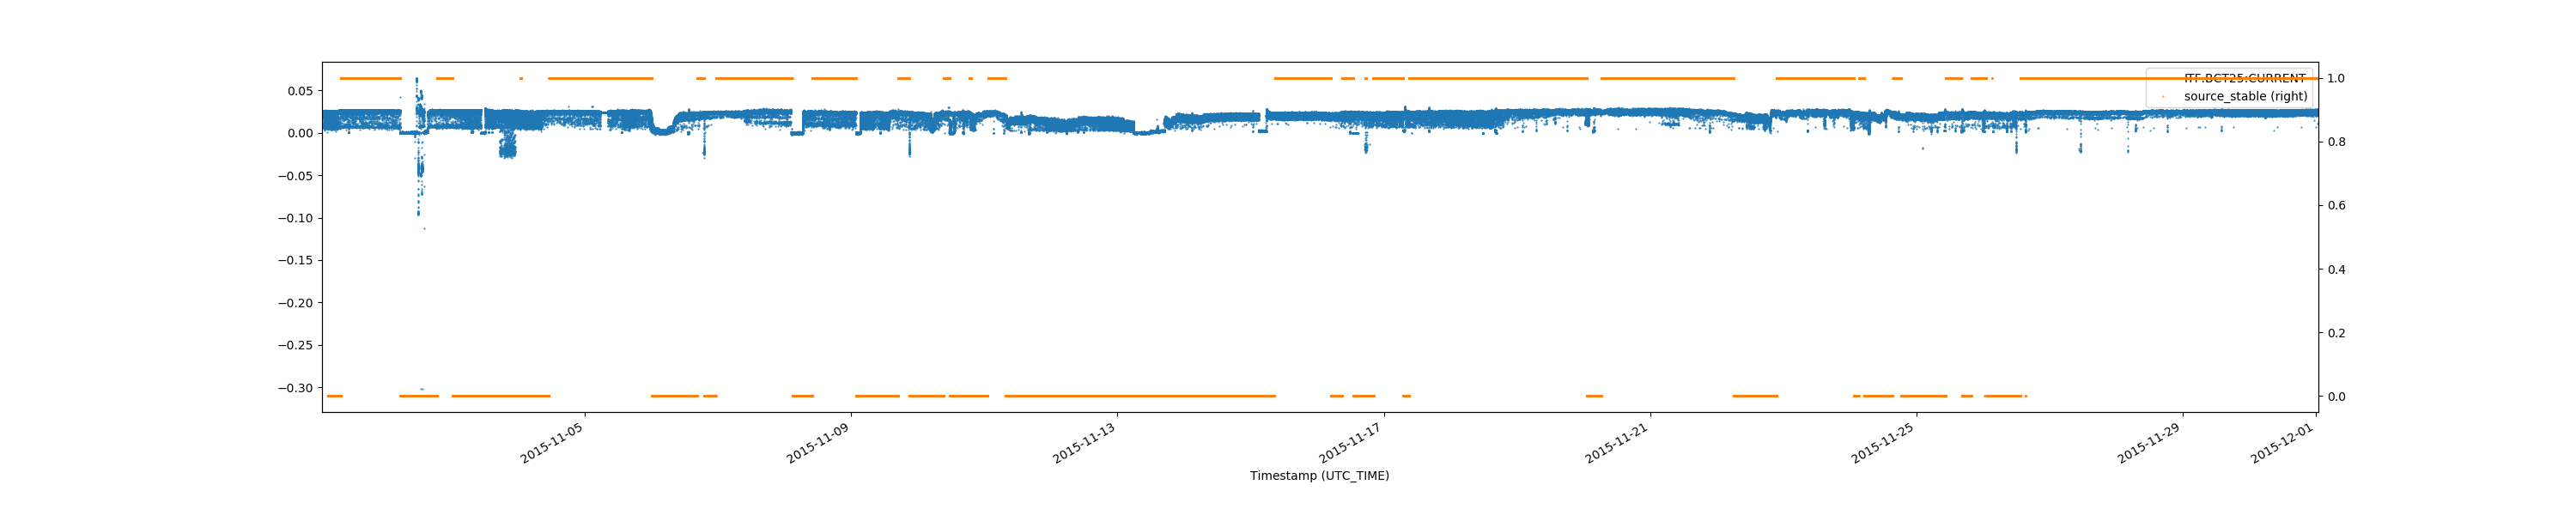

In [42]:
%matplotlib notebook

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,6)

ax1 = df.plot(x='Timestamp (UTC_TIME)', y=['ITF.BCT25:CURRENT', 'source_stable'], secondary_y=['source_stable'], style='.', markersize=1)
plt.show()

#### Voltage Breakdowns

<IPython.core.display.Javascript object>


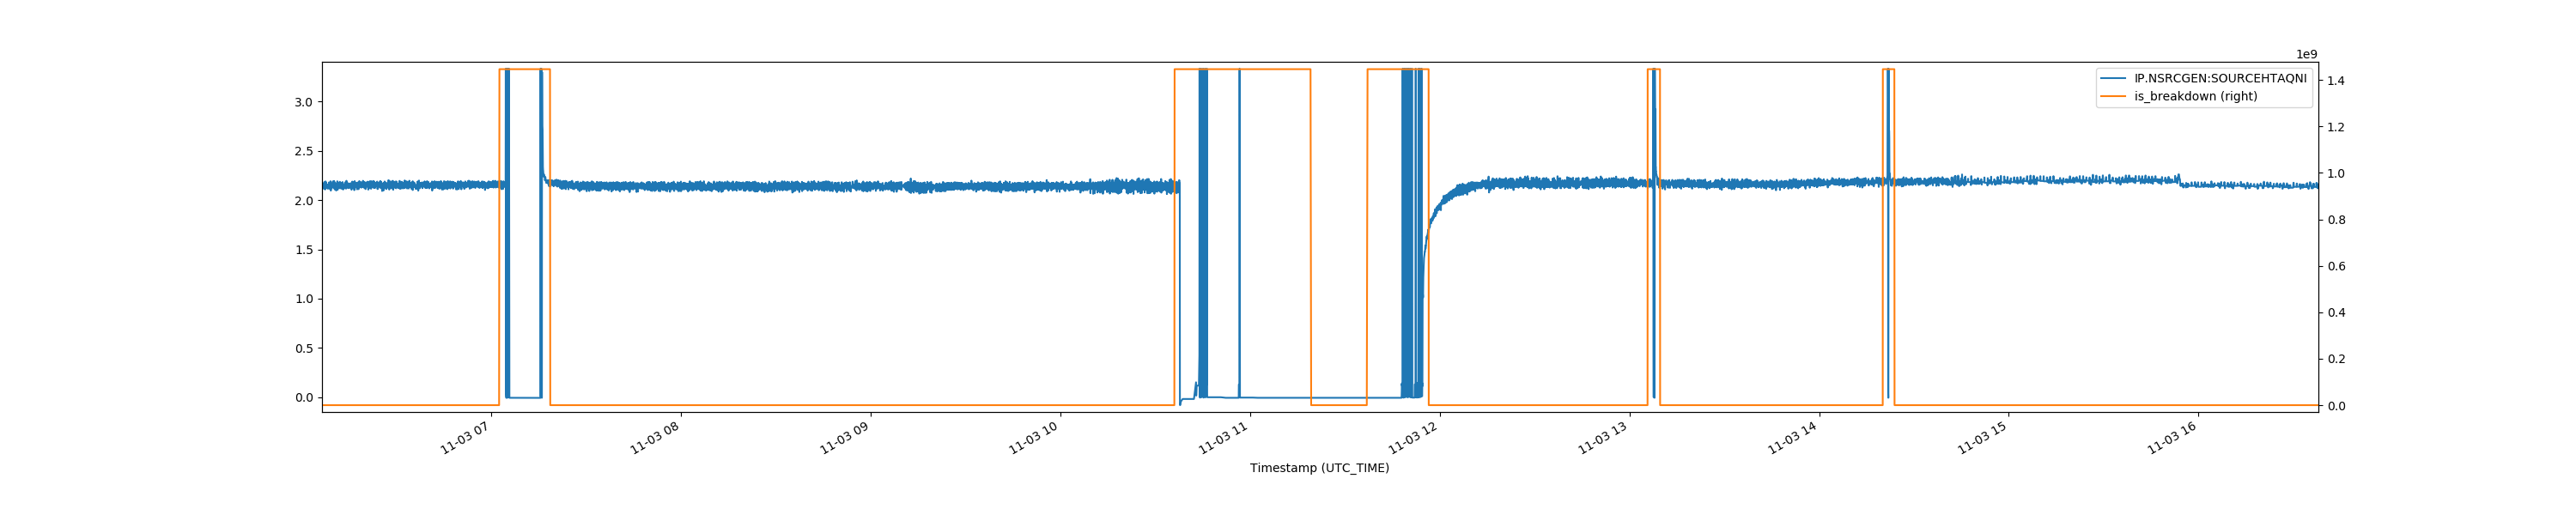

In [34]:
%matplotlib notebook

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,6)

s = df.loc[(df['Timestamp (UTC_TIME)'] >= '2018-11-09 17:58.500') & (df['Timestamp (UTC_TIME)'] <= '2018-11-09 18:02')].copy()

ax1 = df.plot(x='Timestamp (UTC_TIME)', y=['IP.NSRCGEN:SOURCEHTAQNI', 'is_breakdown'], secondary_y=['is_breakdown'])
plt.show()

Now we can save the frame as a csv file. To save storage and increase loading time we set consequitve duplicates to nan. This can be reversed while loading using pd.fillna

In [35]:
df[df.shift(1)==df] = np.nan
df.to_csv(output_file, index=False)